In [1]:
library(fma)
library(fpp)
library(forecast)

Loading required package: tseries
Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: expsmooth
Loading required package: lmtest


## 2a) Describe Series

There is trend and seasonality in this data.
The Seasonplot shows that Q1 & Q2 are fairly steady, but there is a decrease in Q3. Then back up in Q4.
The YOY trend is mostly up in the large middle section. Had a bad few years in early 2000, but it is slowly recovering.

As it looks right now, we will probably want to use the Holt-Winters model and put a highish number on Alpha to use the more recent observations. Probably have a fairly strong number on the seaonality too.

In [2]:
ds_full = ukcars
start(ukcars)
end(ukcars)

[1] 1977    1

[1] 2005    1

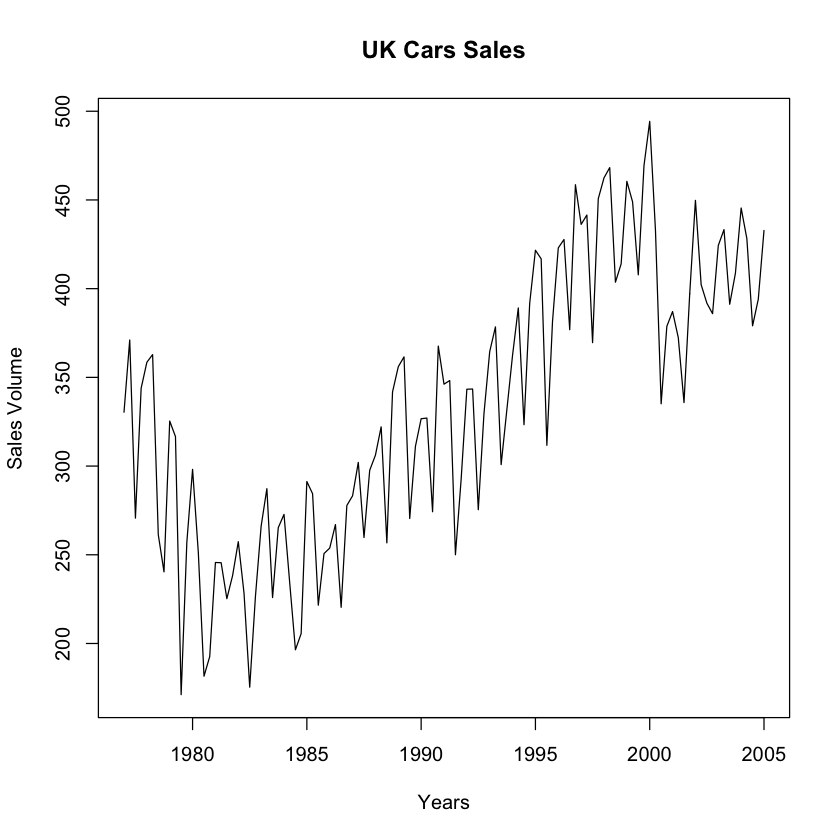

In [3]:
plot(ds_full, main="UK Cars Sales", xlab="Years", ylab="Sales Volume")

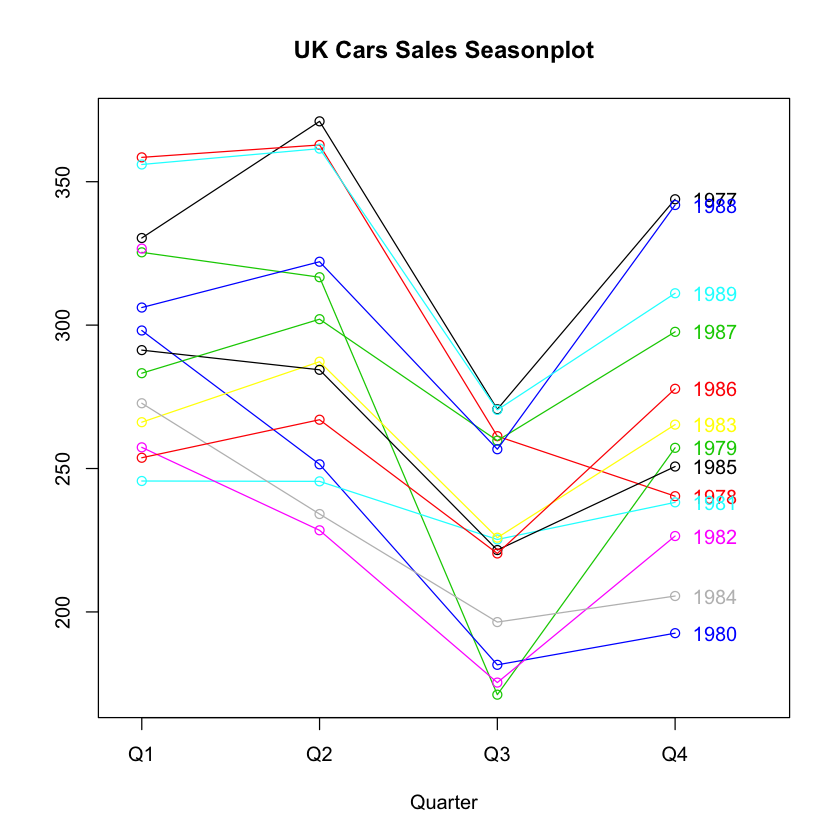

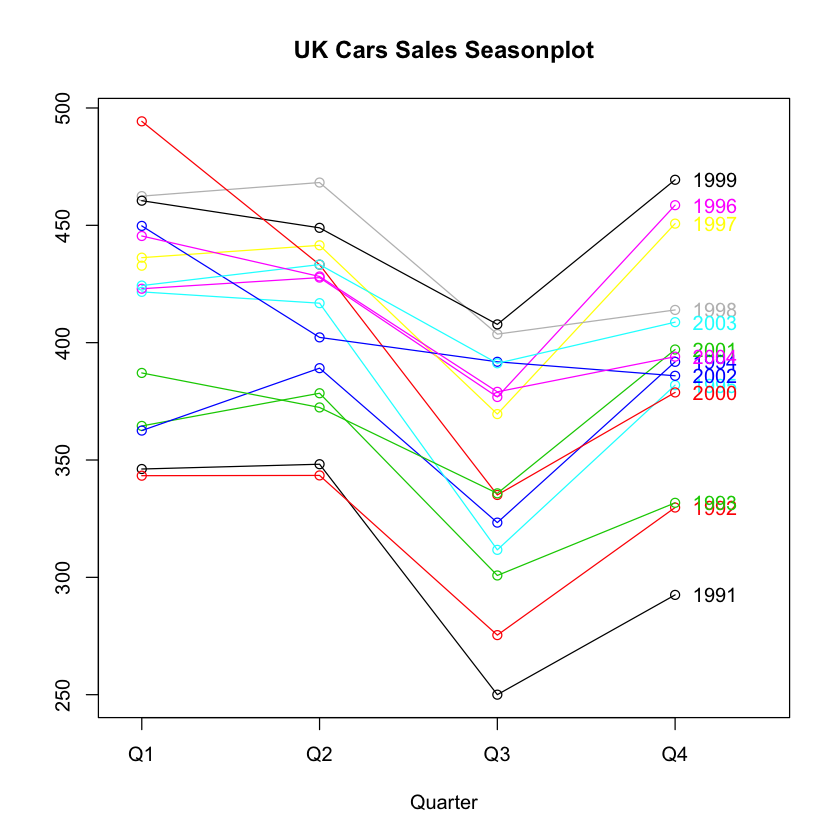

In [4]:
numyears = end(ds_full)[1] - start(ds_full)[1]
seasonplot(window(ds_full, start=1977, end=1990), year.labels=TRUE, col=1:14, main="UK Cars Sales Seasonplot")
seasonplot(window(ds_full, start=1991, end=2005), year.labels=TRUE, col=1:15, main="UK Cars Sales Seasonplot")

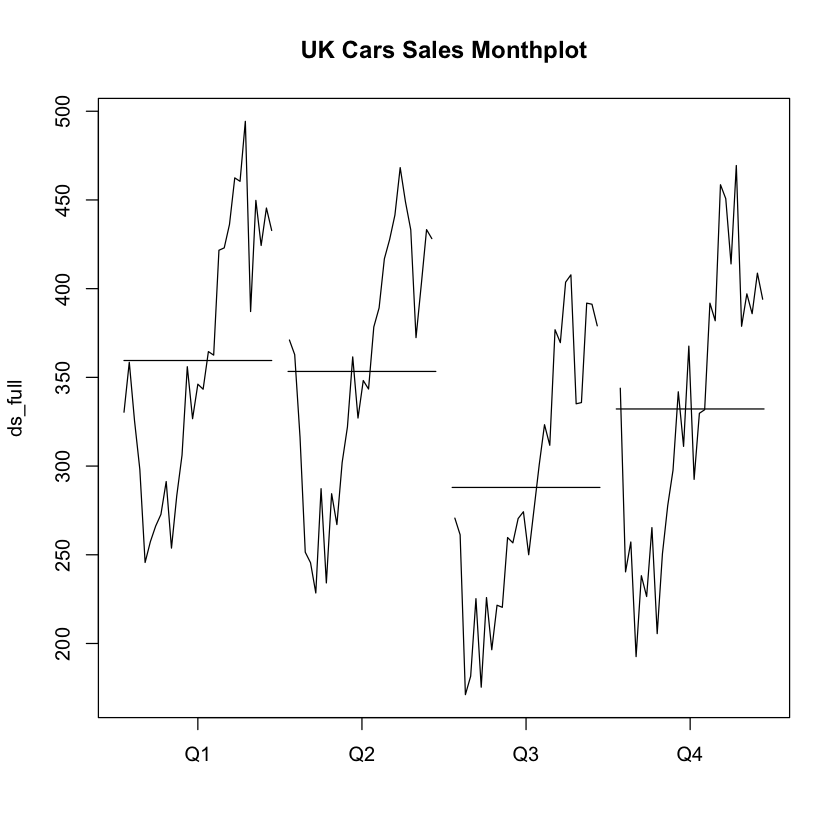

In [5]:
monthplot(ds_full, main="UK Cars Sales Monthplot")

## 2b) STL

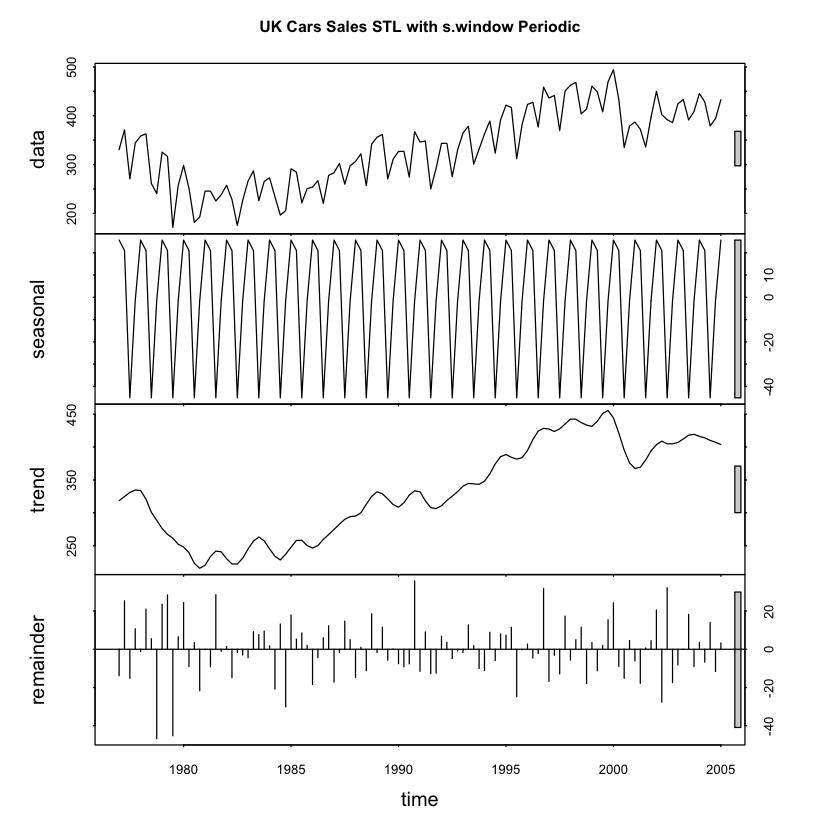

In [6]:
ds_stl = stl(ds_full, s.window="periodic")
plot(ds_stl, main="UK Cars Sales STL with s.window Periodic")

## 2b) Seasonally Adjusted Data

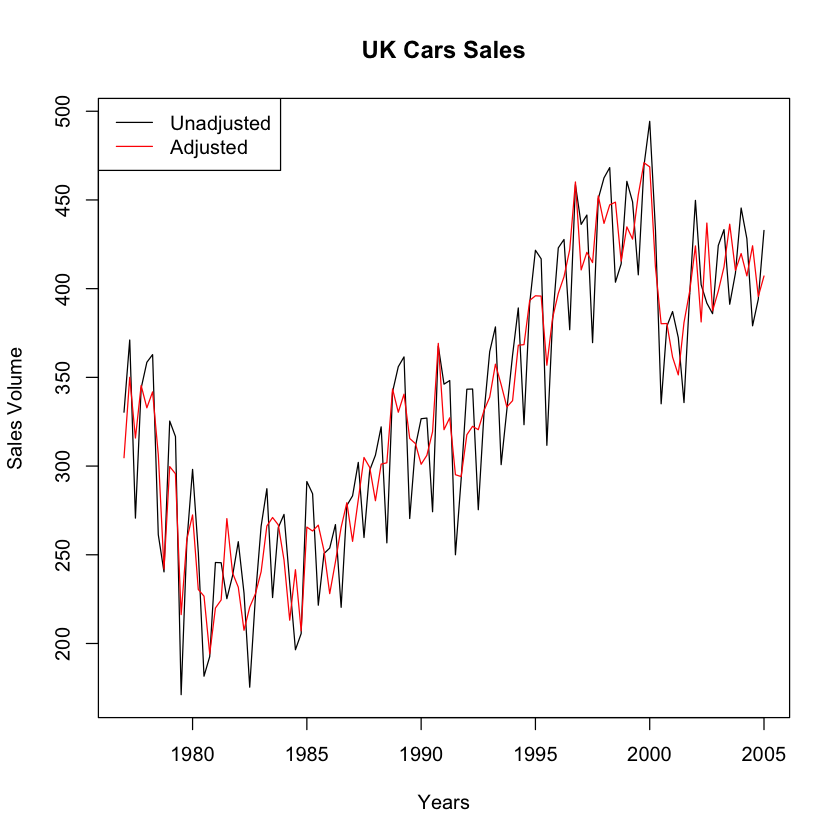

In [7]:
ds_sa = seasadj(ds_stl)

plot(ds_full, main="UK Cars Sales", ylab="Sales Volume", xlab="Years")
lines(ds_sa, col="red")
legend("topleft", legend=c('Unadjusted', 'Adjusted'), col=c("black", "red"), lty=c(1,1))

## 2c) Forecast

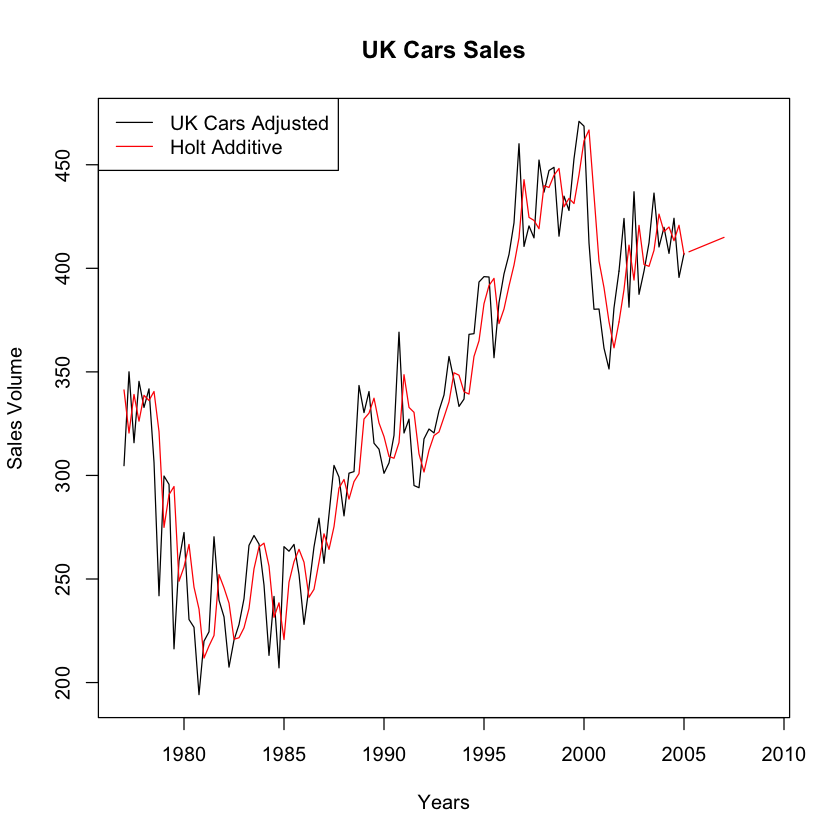

In [8]:
# Holt Linear Model
holt = holt(ds_sa, h=8)

plot(ds_sa, xlim=c(start(ukcars)[1], end(ukcars)[1]+4), main="UK Cars Sales", ylab="Sales Volume", xlab="Years")
abline(a=0, b=0)

# Plot the fitted values to original
lines(fitted(holt), col="red")
# Plot the forecasted values
lines(holt$mean, col="red")

legend("topleft"
       , lty=1
       , col=c("black", "red")
       , c("UK Cars Adjusted", "Holt Additive")
       )

## 2d) Summarize Model


In [9]:
summary(holt)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = ds_sa, h = 8) 

  Smoothing parameters:
    alpha = 0.5962 
    beta  = 1e-04 

  Initial states:
    l = 340.2744 
    b = 1.0018 

  sigma:  25.314

     AIC     AICc      BIC 
1272.482 1272.852 1283.391 

Error measures:
                     ME     RMSE      MAE        MPE     MAPE   MASE       ACF1
Training set -0.6725216 25.31401 20.10156 -0.7566151 6.492304 0.6551 0.03864727

Forecasts:
        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2005 Q2       407.9770 375.5358 440.4182 358.3625 457.5916
2005 Q3       408.9712 371.1989 446.7435 351.2034 466.7390
2005 Q4       409.9654 367.5250 452.4058 345.0584 474.8724
2006 Q1       410.9596 364.3146 457.6046 339.6222 482.2970
2006 Q2       411.9538 361.4519 462.4558 334.7177 489.1899
2006 Q3       412.9480 358.8623 467.0338 330.2310 495.6650
2006 Q4       413.9422 356.4948 471.3897 326.0839 501.8005
2007 Q1       414.9364 354.3123 475.5605 322.219

## 2e) Re-Seasonalize

In [10]:
lastyear = rep(ds_stl$time.series[110:113, "seasonal"], 2)
ds_fc = holt$mean + lastyear

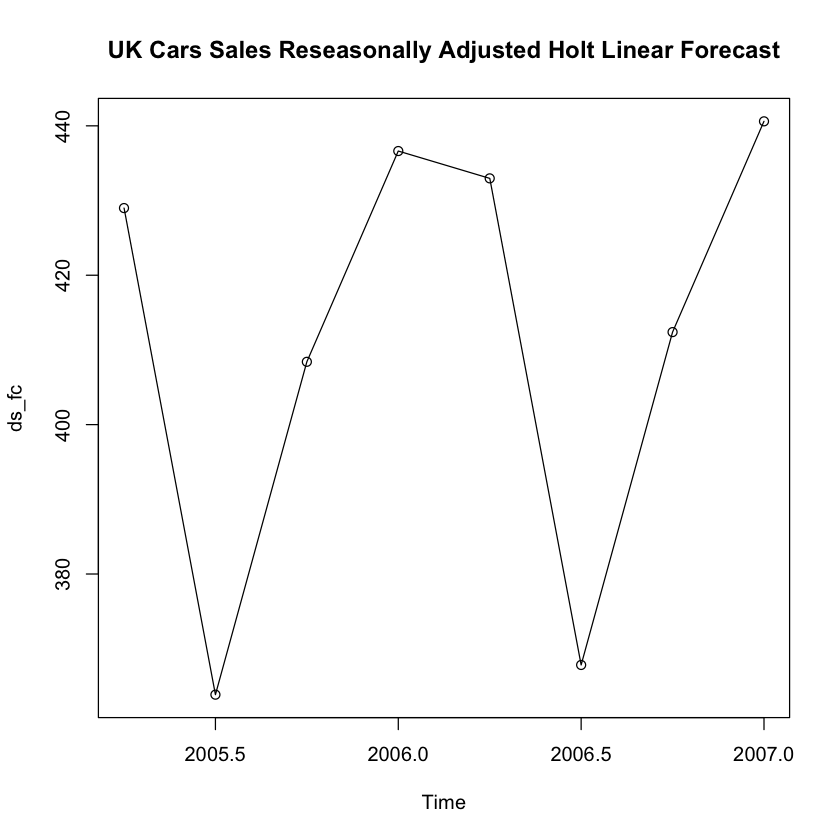

In [11]:
plot(ds_fc, type="o", main="UK Cars Sales Reseasonally Adjusted Holt Linear Forecast")

## 2f)

I think it looks reasonable. The seasonplot of the previous 15 years shows that Q1 is big, Q2 goes down just a bit, Q3 goes down drastically, and Q4 doesn't quite come back up to Q1/Q2 levels.
This new plot of the forecast has that same seasonality.

## 2g) ETS

I take this question to mean do an ETS on the original Seasonally Adjusted data to let it find the optimal model

This ETS is telling me that SES is the optimal model (No Trend, No Seasonality) with Additive Error. 

In [12]:
holt_ets = ets(ds_sa)
holt_ets_forecast = forecast(holt_ets, h=8)
summary(holt_ets)

ETS(A,N,N) 

Call:
 ets(y = ds_sa) 

  Smoothing parameters:
    alpha = 0.6167 

  Initial states:
    l = 318.3843 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259939 25.22788 20.21963 -0.1384294 6.508415 0.6589481
                   ACF1
Training set 0.02657539


## Making Sure I understand results of ETS

Since I believe the ETS is telling me I have an SES model, I want to make sure I get the same results as the ETS when I run my own SES model. It looks like I do get really close alpha results and exact same RMSE results.

In [13]:
set.seed(1)

holt_ets = ets(ds_sa)
summary(holt_ets)

hwSeasonal = ses(ds_sa)
summary(hwSeasonal)

ETS(A,N,N) 

Call:
 ets(y = ds_sa) 

  Smoothing parameters:
    alpha = 0.6167 

  Initial states:
    l = 318.3843 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259939 25.22788 20.21963 -0.1384294 6.508415 0.6589481
                   ACF1
Training set 0.02657539

Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(x = ds_sa) 

  Smoothing parameters:
    alpha = 0.6169 

  Initial states:
    l = 318.3564 

  sigma:  25.2279

     AIC     AICc      BIC 
1267.711 1267.821 1273.166 

Error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 1.259903 25.22788 20.21955 -0.1383556 6.508426 0.6589453
                   ACF1
Training set 0.02639917

Forecasts:
        Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2005 Q2       406.1904 373.8596 4

## 2h) RMSE Compare

The RMSE of the first fitted model is pretty big, 25. The RMSE of this new model is very close to 0, .00000000000009 ish. Meaning it fits the data quite well.

## 2i) Plot future

The result from the ETS (blue line) looks silly. Since it is an SES model it is just straight line. At least the Holt Linear Model has a slope to it showing some trend. The fitted values are very much the same, so I don't understand why the ETS would think that no trend is in there. I get why it didn't find any seasonality, because we adjusted the data for seasonality.

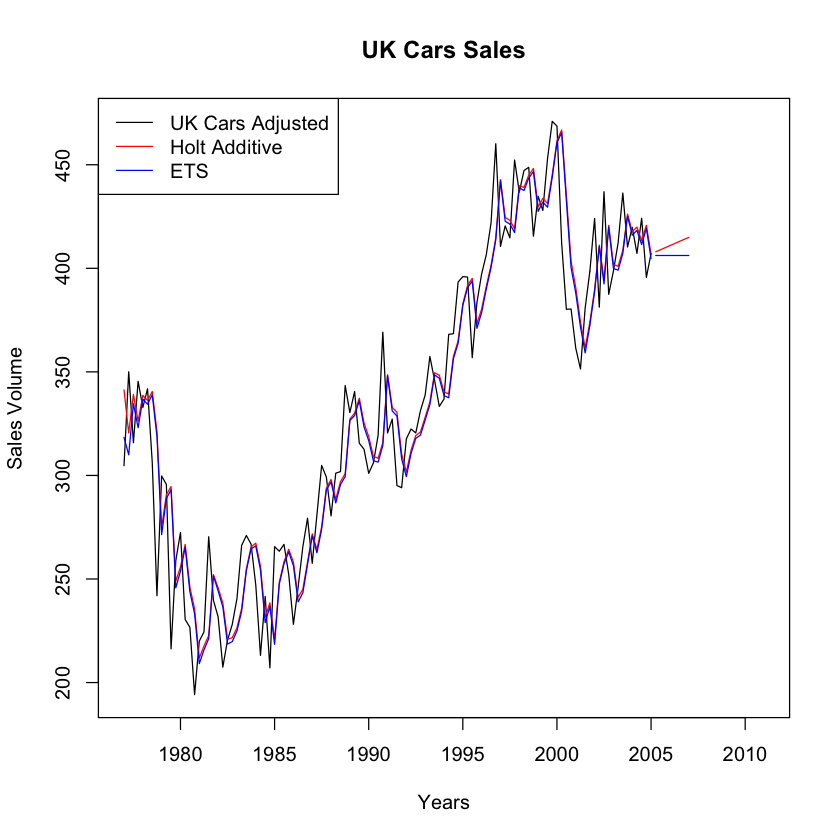

In [14]:
plot(ds_sa, xlim=c(start(ukcars)[1], end(ukcars)[1]+6), main="UK Cars Sales", ylab="Sales Volume", xlab="Years")

# Plot the fitted values to original
lines(fitted(holt), col="red")
# Plot the forecasted values
lines(holt$mean, col="red")

lines(fitted(holt_ets), col="blue")
lines(holt_ets_forecast$mean, col="blue")

legend("topleft"
       , lty=1
       , col=c("black", "red", "blue")
       , c("UK Cars Adjusted", "Holt Additive", "ETS")
       )